### Training of UNET-RESNET34 model on RTK Dataset

In [28]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

Wed Mar 17 18:26:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    33W /  70W |   6902MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
from fastai.vision import *
from fastai.vision.interpret import *
from fastai.callbacks.hooks import *
from pathlib import Path
from fastai.utils.mem import *
torch.backends.cudnn.benchmark=True

In [30]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
path = Path('gdrive/My Drive/Colab Notebooks/')
path.ls()

[PosixPath('gdrive/My Drive/Colab Notebooks/codes.txt'),
 PosixPath('gdrive/My Drive/Colab Notebooks/.ipynb_checkpoints'),
 PosixPath('gdrive/My Drive/Colab Notebooks/valid.txt'),
 PosixPath('gdrive/My Drive/Colab Notebooks/colourlabels'),
 PosixPath('gdrive/My Drive/Colab Notebooks/images'),
 PosixPath('gdrive/My Drive/Colab Notebooks/labels'),
 PosixPath('gdrive/My Drive/Colab Notebooks/Untitled0.ipynb'),
 PosixPath('gdrive/My Drive/Colab Notebooks/RoadSurfaceSegmentation.ipynb'),
 PosixPath('gdrive/My Drive/Colab Notebooks/TEST.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/test_video.mp4'),
 PosixPath('gdrive/My Drive/Colab Notebooks/pathole5.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/pathole4.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/pathole3.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/pathhole2.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/pathhole1.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/pathhole5.jpg'),
 PosixPath('gdrive/My Drive/Col

In [34]:
path_lbl = path/'labels'
path_img = path/'images'

In [35]:
fnames = get_image_files(path_img)
fnames[:3]
len(fnames)

701

In [36]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]
len(lbl_names)

701

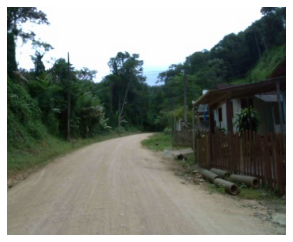

In [37]:
img_f = fnames[139]
img = open_image(img_f)
img.show(figsize=(5,5))

In [38]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

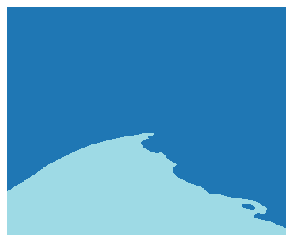

In [39]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [40]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([288, 352]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

In [46]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 8209MB of GPU RAM free


In [47]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [48]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [51]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['manholeCover']

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [52]:
metrics=acc_rtk
wd=1e-2

In [53]:
balanced_loss = CrossEntropyFlat(axis=1, weight=torch.tensor([1.0,5.0,6.0,7.0,75.0,1000.0,3100.0,3300.0,0.0,270.0,2200.0,1000.0,180.0]).cuda())

In [54]:
learn = unet_learner(data, models.resnet34, metrics=metrics, loss_func=balanced_loss, wd=wd)

epoch,train_loss,valid_loss,acc_rtk,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


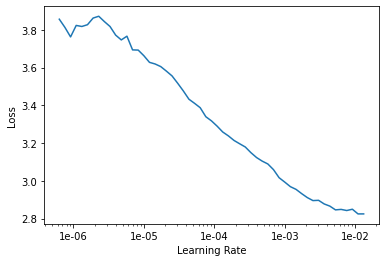

In [56]:
#CUDA_LAUNCH_BLOCKING=1
lr_find(learn)
learn.recorder.plot()

In [57]:
lr=1e-4

In [58]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_rtk,time
0,2.825742,2.649345,0.100898,00:49
1,2.521294,2.313853,0.195008,00:50
2,2.071738,1.859656,0.647364,00:49
3,1.721732,1.556502,0.587214,00:49
4,1.459821,2.252451,0.637007,00:49
5,1.308118,1.263103,0.713593,00:49
6,1.256283,1.003850,0.777886,00:49
7,1.045056,0.903440,0.795632,00:49
8,0.892240,1.008388,0.755425,00:49


epoch,train_loss,valid_loss,acc_rtk,time
0,2.825742,2.649345,0.100898,00:49
1,2.521294,2.313853,0.195008,00:50
2,2.071738,1.859656,0.647364,00:49
3,1.721732,1.556502,0.587214,00:49
4,1.459821,2.252451,0.637007,00:49
5,1.308118,1.263103,0.713593,00:49
6,1.256283,1.003850,0.777886,00:49
7,1.045056,0.903440,0.795632,00:49
8,0.892240,1.008388,0.755425,00:49
9,0.919836,0.739001,0.827747,00:49


In [59]:
learn.fit_one_cycle(100, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_rtk,time
0,0.758094,0.686564,0.829445,00:50
1,0.706750,0.652492,0.834141,00:49
2,0.668010,0.632793,0.838508,00:49
3,0.637982,0.611517,0.841935,00:49
4,0.587502,0.594977,0.841768,00:49
5,0.588219,0.576532,0.842146,00:49
6,0.584333,0.562825,0.846140,00:49
7,0.576902,0.545035,0.850006,00:49
8,0.575153,0.531787,0.850410,00:49
9,0.543988,0.521240,0.850927,00:49


In [60]:
learn.save('my_export')